In [1]:
#!pip install hdbscan umap-learn

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import hdbscan
import numpy as np
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# HDBSCAN

In [81]:
import warnings

def hdbscan_clustering_single_figure(datasets, min_cluster_size=5, min_samples=1, som_metric='euclidean', 
                                     min_variance=1e-6, pca_dim=None, silhouette_sample_size=5000,
                                     linkage_truncate=20, max_cols=3):
    """
    Run HDBSCAN on n-gram datasets:
      - df columns: 'ngram' + one column per virus type (counts)
      - Samples = n-grams, features = virus frequencies

    Visualization panels per dataset (3 columns):
      1. PCA scatter colored by cluster (without legend)
      2. Truncated single linkage tree
      3. Membership probabilities per point

    All datasets are arranged in a single figure grid (max_cols datasets per row).

    Optional parameters:
      - min_variance: remove virus-columns with near-zero variance
      - pca_dim: if set, reduce features to this dimension with PCA before HDBSCAN
      - silhouette_sample_size: number of samples to compute silhouette (None = all)
      - linkage_truncate: number of clusters to show in truncated single linkage tree
    """
    # Suppress all warnings temporarily
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        n_datasets = len(datasets)
        n_panels = 3  # PCA, Single linkage, Membership
        n_rows = math.ceil(n_datasets / max_cols)
        fig, axes = plt.subplots(n_rows, n_panels*max_cols, figsize=(6*max_cols, 5*n_rows))
        
        if n_rows == 1:
            axes = np.expand_dims(axes, axis=0)
        
        results = []

        for idx, (name, df) in enumerate(datasets.items()):
            # Clean
            if "Unnamed: 0" in df.columns:
                df = df.drop(columns=["Unnamed: 0"])
            if "ngram" not in df.columns:
                raise ValueError(f"Dataset '{name}' must contain an 'ngram' column.")

            virus_cols = [c for c in df.columns if c != "ngram"]
            X = df[virus_cols].values.astype(float)
            X = np.log1p(X)
            X = VarianceThreshold(threshold=min_variance).fit_transform(X)

            # Remove duplicates
            n_before = X.shape[0]
            X = np.unique(X, axis=0)
            n_after = X.shape[0]
            n_duplicates = n_before - n_after
            if n_duplicates > 0:
                print(f"{n_duplicates} duplicate rows removed from {name}")

            Xs = StandardScaler().fit_transform(X)
            if pca_dim is not None and pca_dim < Xs.shape[1]:
                Xs = PCA(n_components=pca_dim, random_state=42).fit_transform(Xs)

            model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                    min_samples=min_samples,
                                    metric=som_metric)
            labels_pred = model.fit_predict(Xs)

            n_clusters = len(set(labels_pred)) - (1 if -1 in labels_pred else 0)
            n_noise = int(np.sum(labels_pred == -1))
            mask = labels_pred != -1
            silhouette = None
            if n_clusters > 1 and np.any(mask) and len(set(labels_pred[mask])) > 1:
                try:
                    silhouette = float(silhouette_score(
                        Xs[mask], labels_pred[mask],
                        sample_size=min(silhouette_sample_size, np.sum(mask)),
                        random_state=42
                    ))
                except Exception:
                    silhouette = None

            results.append({
                "n_gram": name,
                "n_clusters": n_clusters,
                "n_noise": n_noise,
                "silhouette_score": silhouette
            })

            # PCA 2D for plotting
            pca_result = PCA(n_components=2, random_state=42).fit_transform(Xs)

            # Odredi poziciju u mreži
            row_idx = idx // max_cols
            col_idx = idx % max_cols
            start_col = col_idx * n_panels
            ax0 = axes[row_idx, start_col]
            ax1 = axes[row_idx, start_col+1]
            ax2 = axes[row_idx, start_col+2]

            # Panel 1: PCA scatter
            unique_labels = np.unique(labels_pred)
            n_labels = len(unique_labels)
            cmap = plt.get_cmap("tab20", n_labels)
            for lbl in unique_labels:
                mask_lbl = labels_pred == lbl
                ax0.scatter(pca_result[mask_lbl,0], pca_result[mask_lbl,1],
                            c=[cmap(lbl if lbl >= 0 else n_labels)]*np.sum(mask_lbl),
                            s=15, edgecolor='none', alpha=0.6)
            ax0.set_title(f"PCA ({name})")
            ax0.set_xlabel("PCA 1")
            ax0.set_ylabel("PCA 2")

            # Panel 2: Single linkage tree
            plt.sca(ax1)
            if hasattr(model, 'single_linkage_tree_'):
                model.single_linkage_tree_.plot(truncate_mode='lastp', p=linkage_truncate,
                                                cmap='viridis', colorbar=True)
            ax1.set_title(f"Single Linkage ({name})")

            # Panel 3: Membership probabilities
            sc = ax2.scatter(pca_result[:,0], pca_result[:,1],
                             c=model.probabilities_, cmap='viridis', s=15, edgecolor='none', alpha=0.7)
            ax2.set_title(f"Membership ({name})")
            ax2.set_xlabel("PCA 1")
            ax2.set_ylabel("PCA 2")
            plt.colorbar(sc, ax=ax2, label="Cluster Membership Probability")

        plt.tight_layout()
        plt.show()
        results_df = pd.DataFrame(results)
        print(results_df)
        return results_df

In [82]:
df6 = pd.read_csv("../csv_data/6gram_matrix_nucleotide_combined.csv")
df7 = pd.read_csv("../csv_data/7gram_matrix_nucleotide_combined.csv")
df8 = pd.read_csv("../csv_data/8gram_matrix_nucleotide_combined.csv")
df9 = pd.read_csv("../csv_data/9gram_matrix_nucleotide_combined.csv")

datasets = {
    "6-gram": df6,
    "7-gram": df7,
    "8-gram": df8,
    "9-gram": df9
}

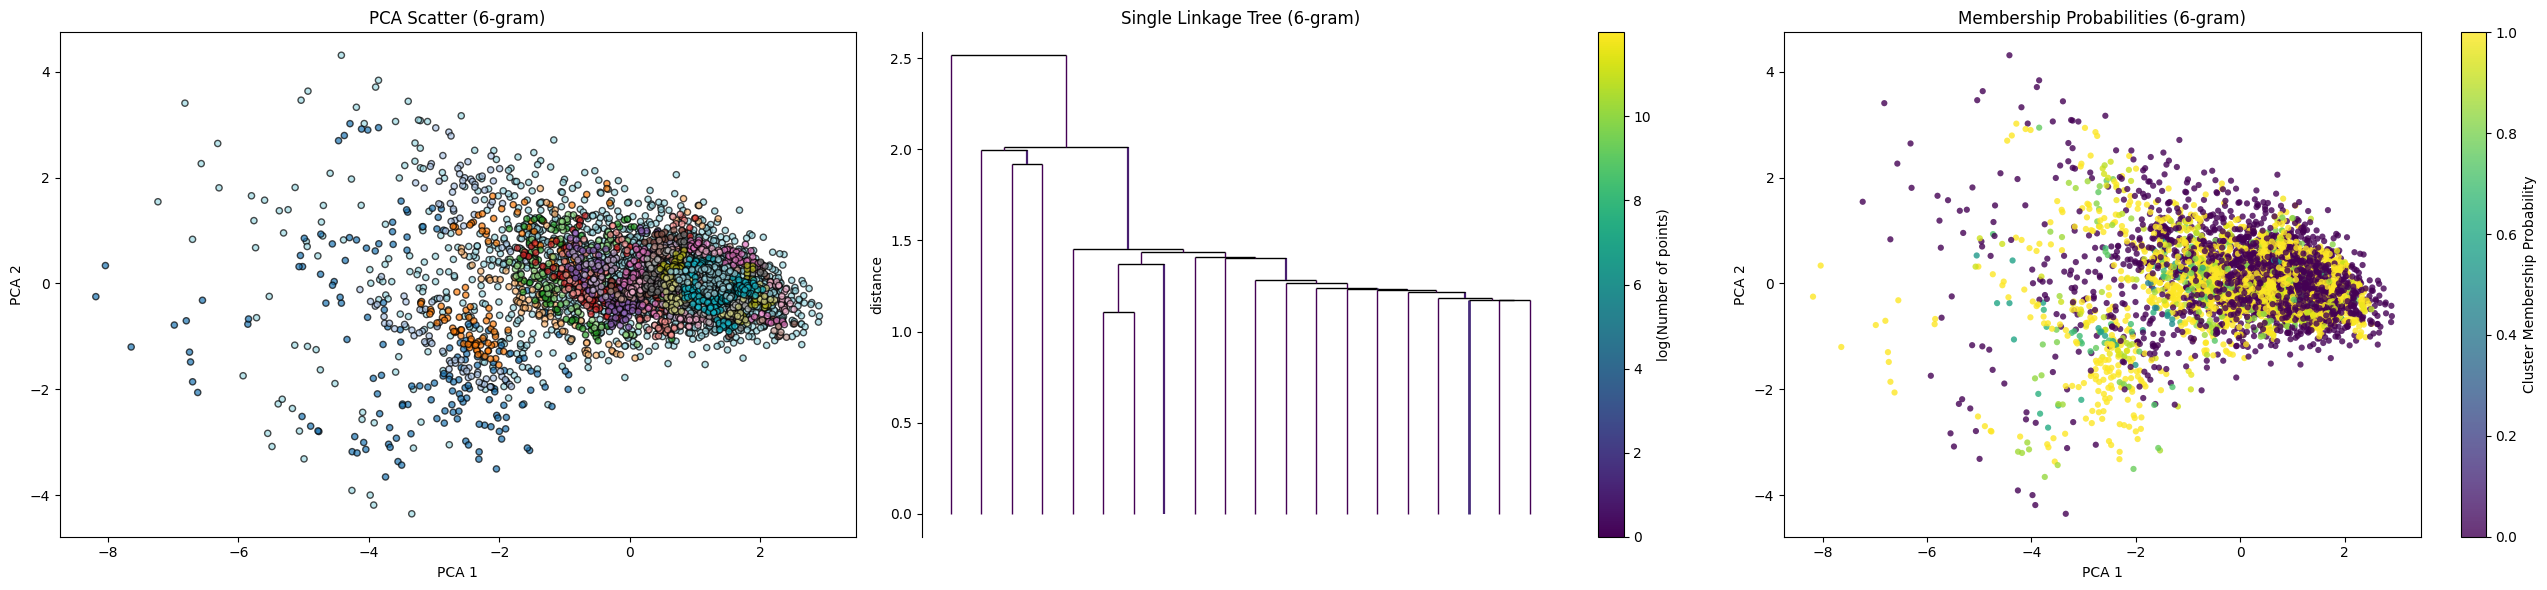

/tmp/ipykernel_4022/787750357.py:56: UserWarning: 122 duplicate rows removed from 7-gram
  warnings.warn(f"{n_before - n_after} duplicate rows removed from {name}")


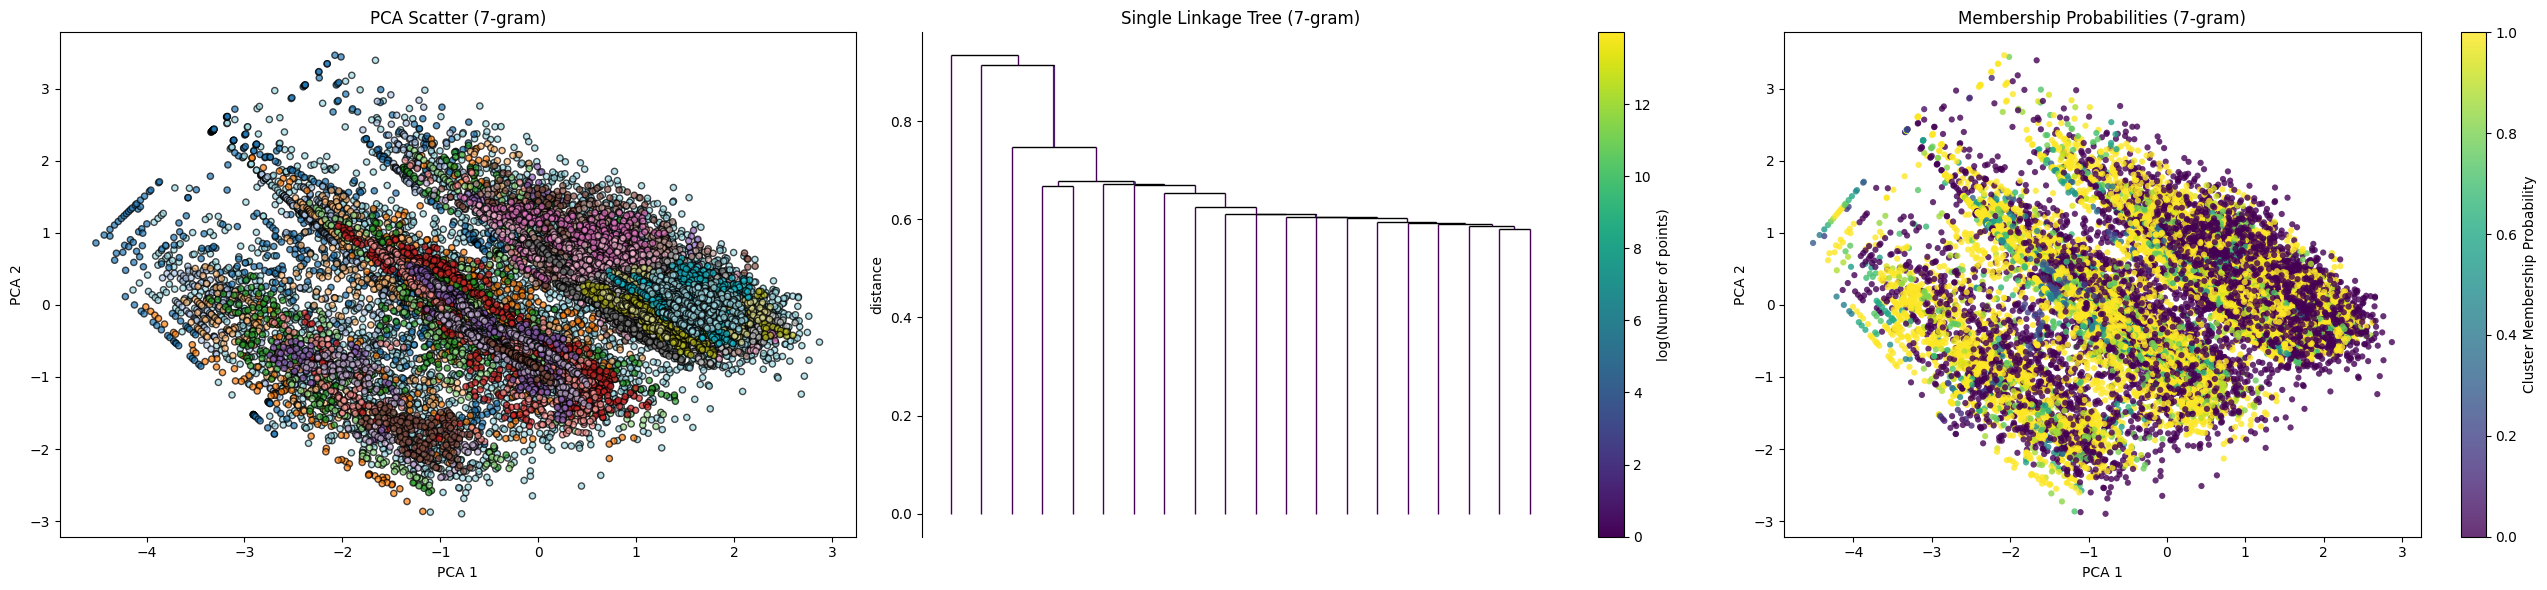

/tmp/ipykernel_4022/787750357.py:56: UserWarning: 17802 duplicate rows removed from 8-gram
  warnings.warn(f"{n_before - n_after} duplicate rows removed from {name}")


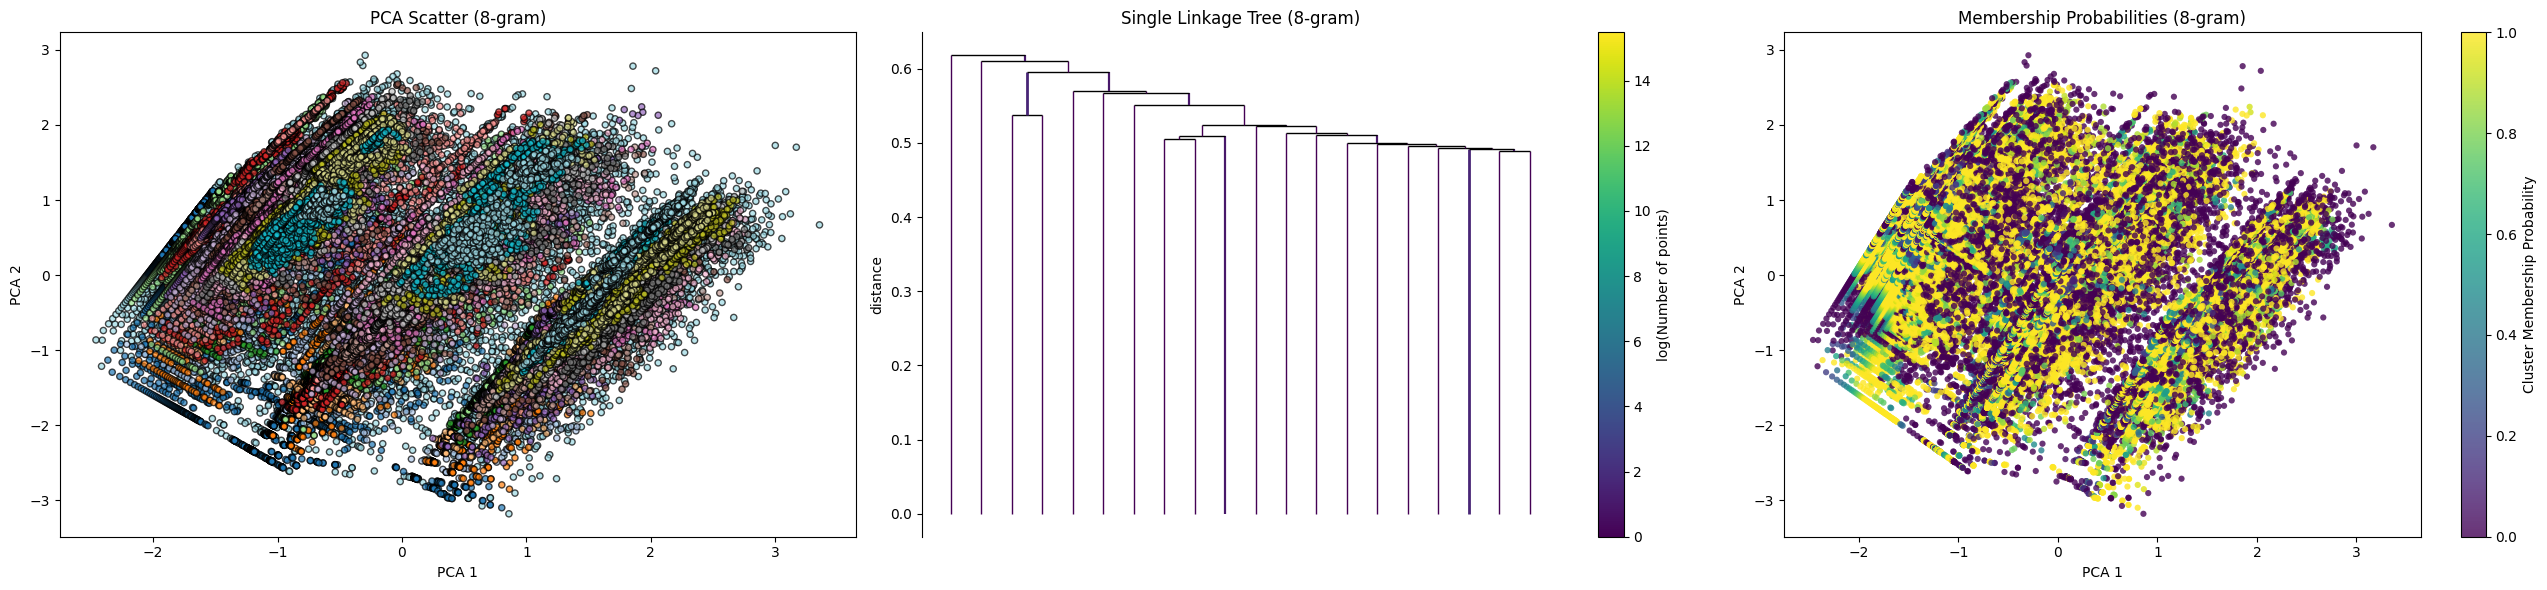

/tmp/ipykernel_4022/787750357.py:56: UserWarning: 148916 duplicate rows removed from 9-gram
  warnings.warn(f"{n_before - n_after} duplicate rows removed from {name}")


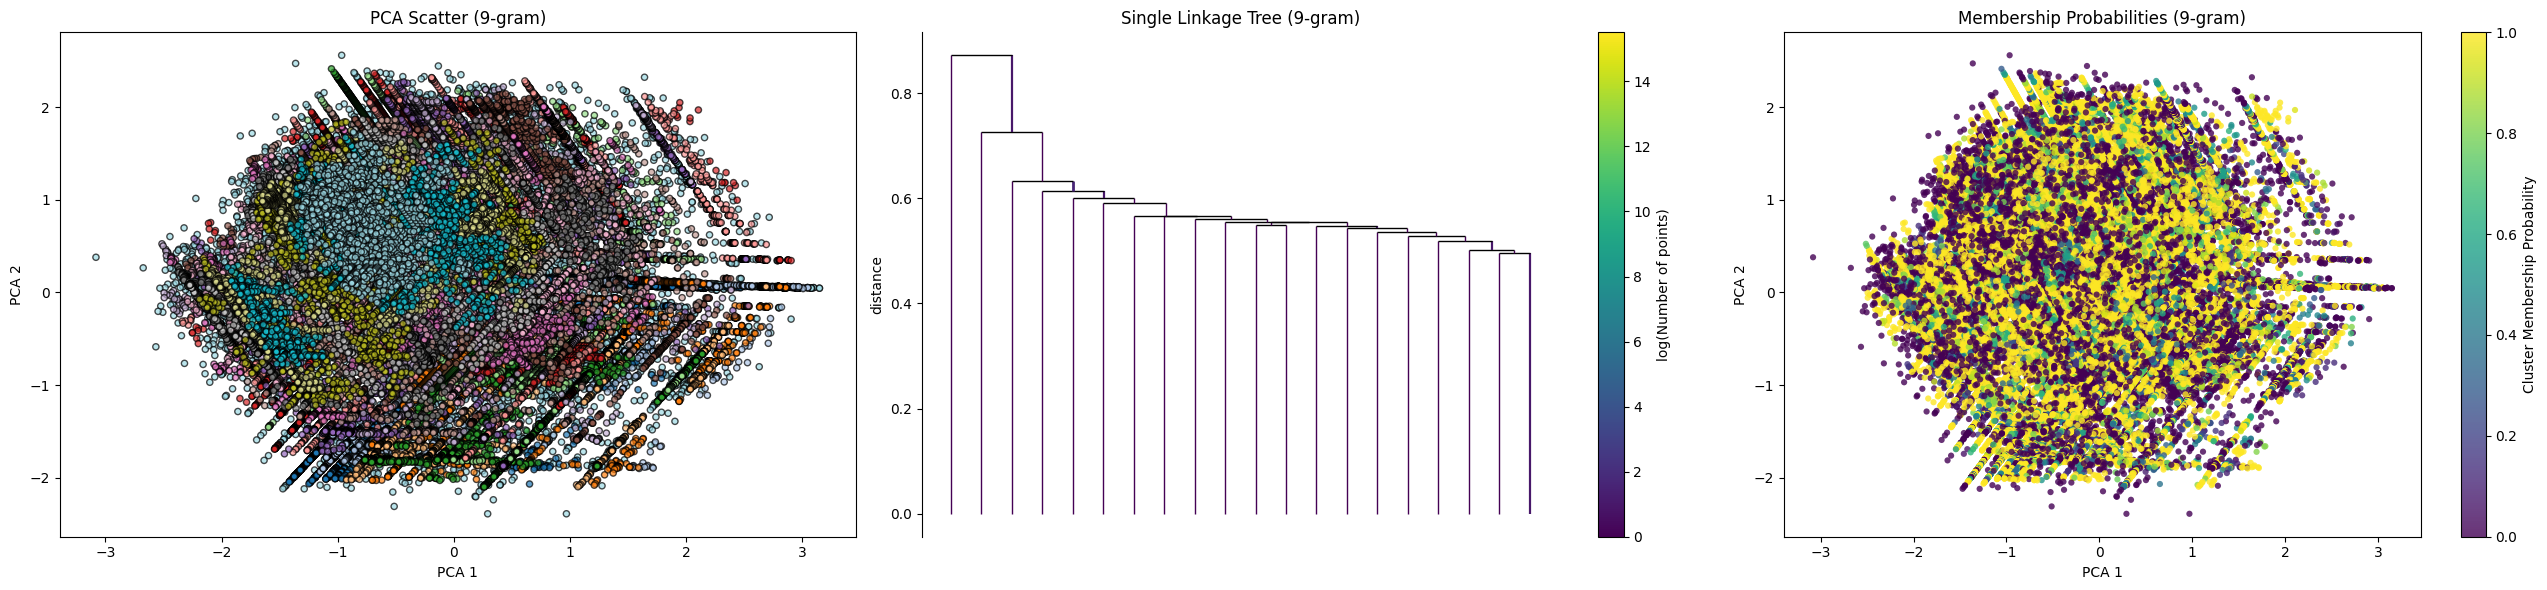

   n_gram  n_clusters  n_noise  silhouette_score
0  6-gram         234     1926          0.239588
1  7-gram        1135     5977          0.294259
2  8-gram        3401    12886          0.295068
3  9-gram        3400    10960          0.293332


In [83]:

results_df = hdbscan_clustering(datasets, pca_dim=10, silhouette_sample_size=5000)

# K-Means

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import math

In [22]:
df6 = pd.read_csv("../csv_data/6gram_matrix_nucleotide_combined.csv")
df7 = pd.read_csv("../csv_data/7gram_matrix_nucleotide_combined.csv")
df8 = pd.read_csv("../csv_data/8gram_matrix_nucleotide_combined.csv")
df9 = pd.read_csv("../csv_data/9gram_matrix_nucleotide_combined.csv")

datasets = {
    "6-gram": df6,
    "7-gram": df7,
    "8-gram": df8,
    "9-gram": df9
}

In [23]:
def kmeans_compute_metrics(datasets, cluster_range=range(2,6), pca_dim=None, silhouette_sample_size=1000, random_state=42):
    """
    Compute KMeans clustering metrics (Silhouette, Calinski-Harabasz, Davies-Bouldin) 
    for each dataset and each k in cluster_range.
    Optionally reduces dimensionality with PCA before clustering to speed up.
    """
    results = []

    for name, df in datasets.items():
        if "Unnamed: 0" in df.columns:
            df = df.drop(columns=["Unnamed: 0"])
        if "ngram" not in df.columns:
            raise ValueError(f"Dataset '{name}' must contain an 'ngram' column.")

        X = df.drop(columns=["ngram"]).values.astype(float)
        Xs = StandardScaler().fit_transform(X)

        # PCA to speed up clustering
        if pca_dim is not None and pca_dim < Xs.shape[1]:
            Xs = PCA(n_components=pca_dim, random_state=random_state).fit_transform(Xs)

        n_samples = Xs.shape[0]

        for k in cluster_range:
            if k > n_samples:
                continue
            model = KMeans(n_clusters=k, random_state=random_state)
            labels = model.fit_predict(Xs)

            # Compute metrics safely
            try:
                sil = silhouette_score(Xs, labels, sample_size=min(silhouette_sample_size, n_samples)) if k > 1 else np.nan
            except:
                sil = np.nan
            try:
                cal = calinski_harabasz_score(Xs, labels) if k > 1 else np.nan
            except:
                cal = np.nan
            try:
                dav = davies_bouldin_score(Xs, labels) if k > 1 else np.nan
            except:
                dav = np.nan

            results.append({
                "dataset": name,
                "k": k,
                "silhouette": sil,
                "calinski": cal,
                "davies": dav
            })

    return pd.DataFrame(results)

In [24]:
metrics_df = kmeans_compute_metrics(
    datasets,
    cluster_range=range(2,6),
    pca_dim=10,
    silhouette_sample_size=1000
)

print(metrics_df) 

   dataset  k  silhouette       calinski    davies
0   6-gram  2    0.441712    3635.071733  0.971397
1   6-gram  3    0.350661    2973.675492  1.193494
2   6-gram  4    0.335521    2708.419081  1.148646
3   6-gram  5    0.311788    2456.638602  1.170200
4   7-gram  2    0.430474    9611.768247  1.188488
5   7-gram  3    0.399625    7340.872172  1.399408
6   7-gram  4    0.317749    6557.614217  1.328198
7   7-gram  5    0.300882    5897.936610  1.374591
8   8-gram  2    0.440909   22448.470460  1.508973
9   8-gram  3    0.436569   19781.986930  1.460010
10  8-gram  4    0.341829   18937.297532  1.285032
11  8-gram  5    0.441492   19977.545629  1.100970
12  9-gram  2    0.559041   53739.492007  0.960735
13  9-gram  3    0.589867   69477.560346  0.877675
14  9-gram  4    0.654940   86748.447484  0.745868
15  9-gram  5    0.722680  133526.031783  0.625391


In [25]:
import matplotlib.pyplot as plt
import math

def plot_kmeans_metrics_grid(metrics_df):
    datasets = metrics_df['dataset'].unique()
    metrics = ['silhouette', 'calinski', '1/davies']
    n_rows = len(metrics)
    n_cols = len(datasets)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharex=True)

    for col, ds in enumerate(datasets):
        subset = metrics_df[metrics_df['dataset']==ds].copy()
        subset['1/davies'] = 1 / subset['davies']

        for row, metric in enumerate(metrics):
            ax = axes[row, col] if n_rows > 1 else axes[col]
            ax.plot(subset['k'], subset[metric], marker='o', label=metric)
            if row == 0:
                ax.set_title(ds)
            if row == n_rows - 1:
                ax.set_xlabel("Number of clusters (k)")
            ax.set_ylabel(metric)
            ax.grid(alpha=0.3)
            ax.legend()

    plt.tight_layout()
    plt.show()


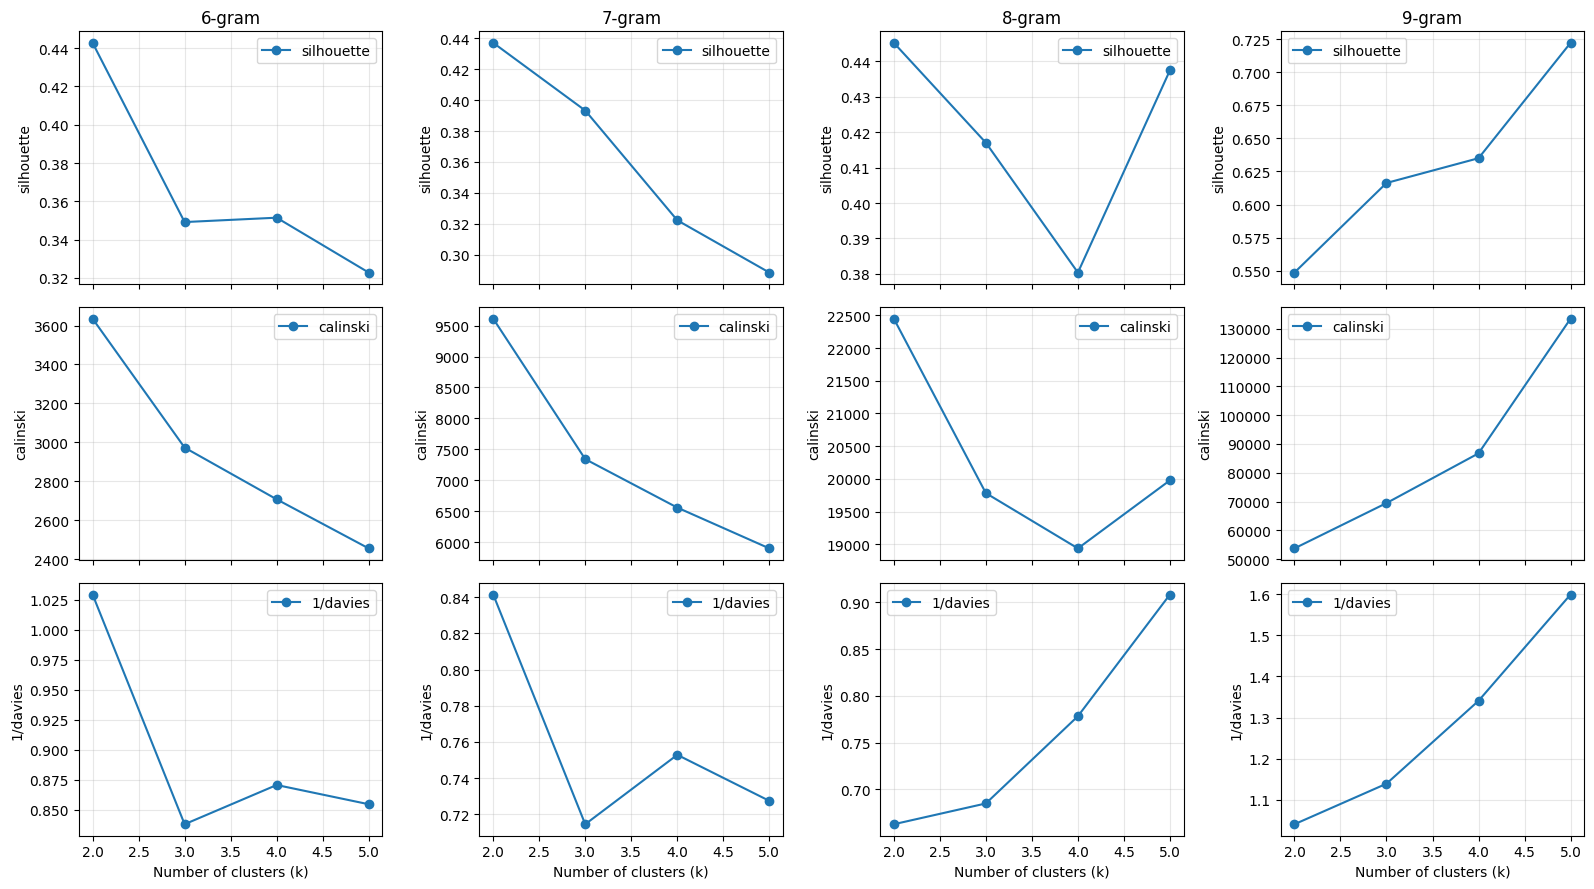

In [26]:
metrics_df = kmeans_compute_metrics(datasets, cluster_range=range(2,6), pca_dim=10)
plot_kmeans_metrics_grid(metrics_df)

In [29]:
def plot_pca_scatter_kmeans_colored(datasets, cluster_range=[3], pca_dim=2, random_state=42, figsize=(12,6)):
    
    fig_cols = 2
    n_datasets = len(datasets)
    n_rows = math.ceil(n_datasets / fig_cols)
    fig, axes = plt.subplots(n_rows, fig_cols, figsize=(figsize[0], figsize[1]*n_rows))
    axes = axes.flatten()

    for i, (name, df) in enumerate(datasets.items()):
        X = df.drop(columns=["ngram"]).values.astype(float)
        Xs = StandardScaler().fit_transform(X)

        # PCA 2D
        target_dim = min(pca_dim, Xs.shape[1])
        X_pca = PCA(n_components=target_dim, random_state=random_state).fit_transform(Xs)

        # KMeans sa prvim k iz cluster_range
        k = cluster_range[0]
        if k > Xs.shape[0]:
            k = Xs.shape[0]
        model = KMeans(n_clusters=k, random_state=random_state)
        labels = model.fit_predict(Xs)

        ax = axes[i]
        unique_labels = np.unique(labels)
        cmap = plt.get_cmap("tab20", len(unique_labels))

        for lbl in unique_labels:
            mask = labels == lbl
            ax.scatter(X_pca[mask,0], X_pca[mask,1],
                       c=[cmap(lbl)]*np.sum(mask), s=15, edgecolor='none', alpha=0.6)

        ax.set_title(f"{name} PCA scatter (k={k})")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.grid(alpha=0.3)

    # Sakrij prazne subplotove
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


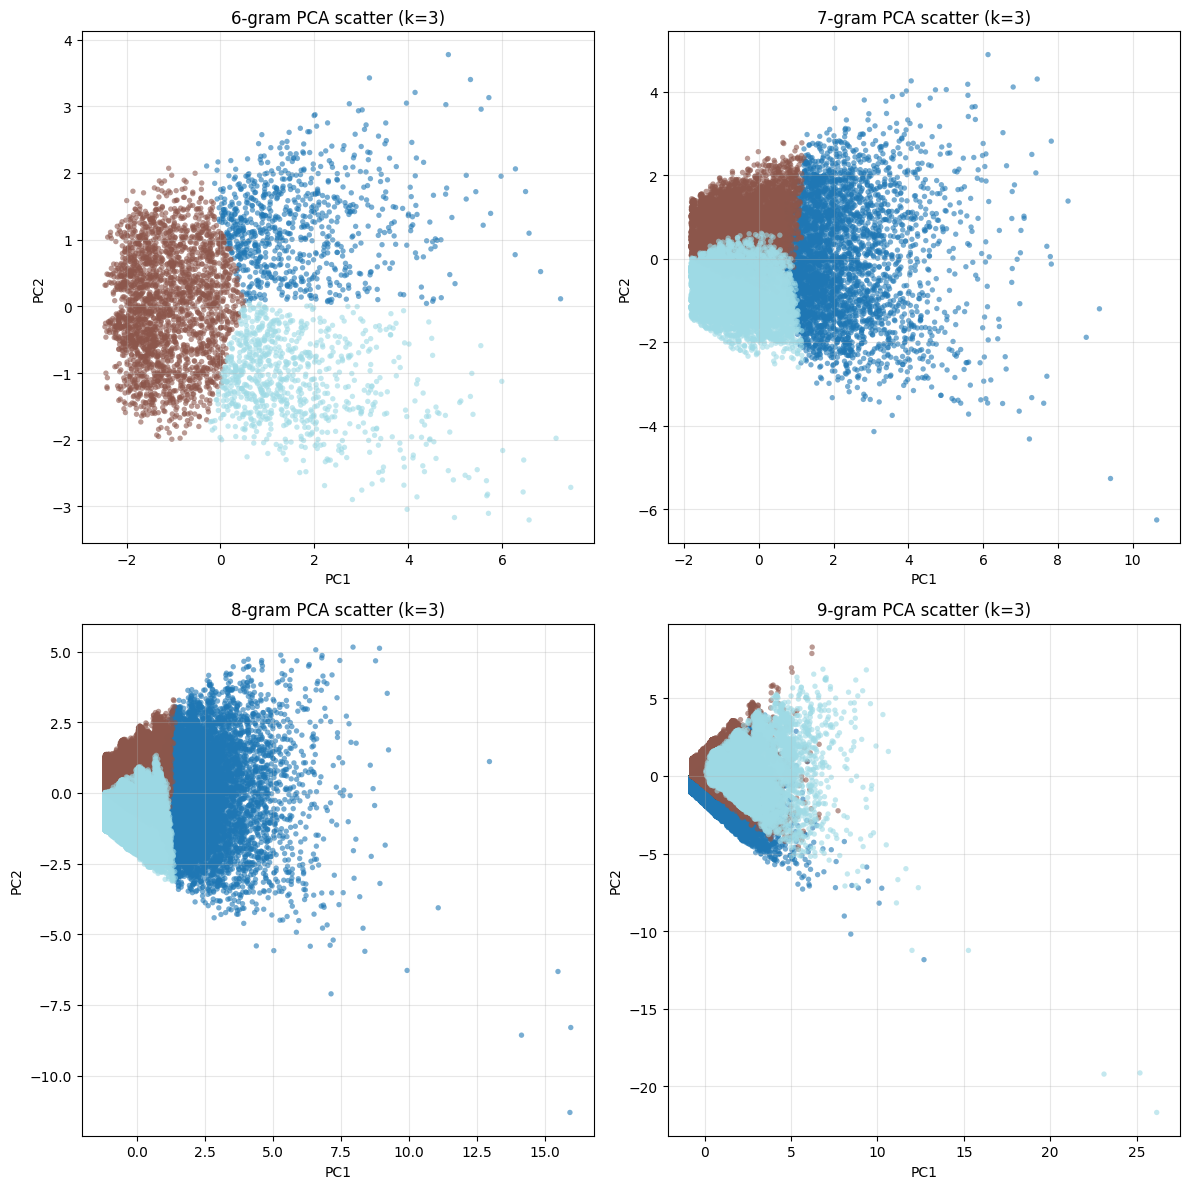

In [28]:
plot_pca_scatter_kmeans_colored(datasets, cluster_range=[3], pca_dim=2, figsize=(12,6))


# SOM

In [1]:
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [8]:
def som(datasets, som_x=15, som_y=15, iterations=1000):
    """
    Train and visualize SOMs for vertical n-gram matrices.

    Expected input: dict {dataset_name: df}, where df has column 'ngram' + one column per virus type.
    Example DF:
        ngram   VirusA  VirusB  VirusC
        AAA     10      3       0
        AAC     2       7       1
        ...
    """
    results = []
    fig, axes = plt.subplots(len(datasets), 2, figsize=(12, 5 * len(datasets)))

    if len(datasets) == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, (name, df) in enumerate(datasets.items()):
        # Drop unwanted columns like 'Unnamed: 0' if present
        if "Unnamed: 0" in df.columns:
            df = df.drop(columns=["Unnamed: 0"])

        # Check for 'ngram' column
        if "ngram" not in df.columns:
            raise ValueError(f"Dataset '{name}' must have a column 'ngram'.")

        # Set 'ngram' as index and transpose so samples = virus types
        mat = df.set_index("ngram")
        mat_T = mat.T

        # Labels are virus types (index after transpose)
        labels = mat_T.index.to_numpy()
        features = mat_T.values.astype(float)

        # Standardize features across n-grams
        scaler = StandardScaler(with_mean=True, with_std=True)
        features_scaled = scaler.fit_transform(features)

        # Train SOM
        som = MiniSom(x=som_x, y=som_y, input_len=features_scaled.shape[1], sigma=1.0, learning_rate=0.5)
        som.random_weights_init(features_scaled)
        som.train_random(features_scaled, num_iteration=iterations)

        # BMU coordinates for each sample
        bmu_coords = np.array([som.winner(x) for x in features_scaled])

        # Map virus labels to integers for coloring
        unique_labels = list(labels)
        label_to_int = {lab: idx for idx, lab in enumerate(unique_labels)}
        color_labels = np.array([label_to_int[lab] for lab in labels])

        # Save results
        results.append({
            "dataset": name,
            "n_viruses": len(labels),
            "n_features": features_scaled.shape[1],
            "n_clusters": len(np.unique(bmu_coords, axis=0))
        })

        # Plot U-Matrix
        ax1 = axes[i, 0]
        ax1.set_title(f"SOM U-Matrix ({name})")
        im = ax1.pcolor(som.distance_map().T, cmap='bone_r')
        fig.colorbar(im, ax=ax1)

        # Plot SOM map colored by virus type
        ax2 = axes[i, 1]
        ax2.set_title(f"SOM colored by virus_type ({name})")
        scatter = ax2.scatter(
            bmu_coords[:, 0], bmu_coords[:, 1],
            c=color_labels, cmap='tab10',
            s=60, edgecolors='k', linewidths=0.5
        )
        ax2.set_xlim(0, som_x)
        ax2.set_ylim(0, som_y)

        handles, _ = scatter.legend_elements()
        ax2.legend(
            handles=handles,
            labels=unique_labels,
            title="virus_type",
            bbox_to_anchor=(1.05, 1), loc='upper left'
        )

    plt.tight_layout()
    plt.show()

    return results


In [9]:
df6 = pd.read_csv("../csv_data/6gram_matrix_nucleotide_combined.csv")
df7 = pd.read_csv("../csv_data/7gram_matrix_nucleotide_combined.csv")
df8 = pd.read_csv("../csv_data/8gram_matrix_nucleotide_combined.csv")
df9 = pd.read_csv("../csv_data/9gram_matrix_nucleotide_combined.csv")

datasets = {
    "6-gram": df6,
    "7-gram": df7,
    "8-gram": df8,
    "9-gram": df9
}

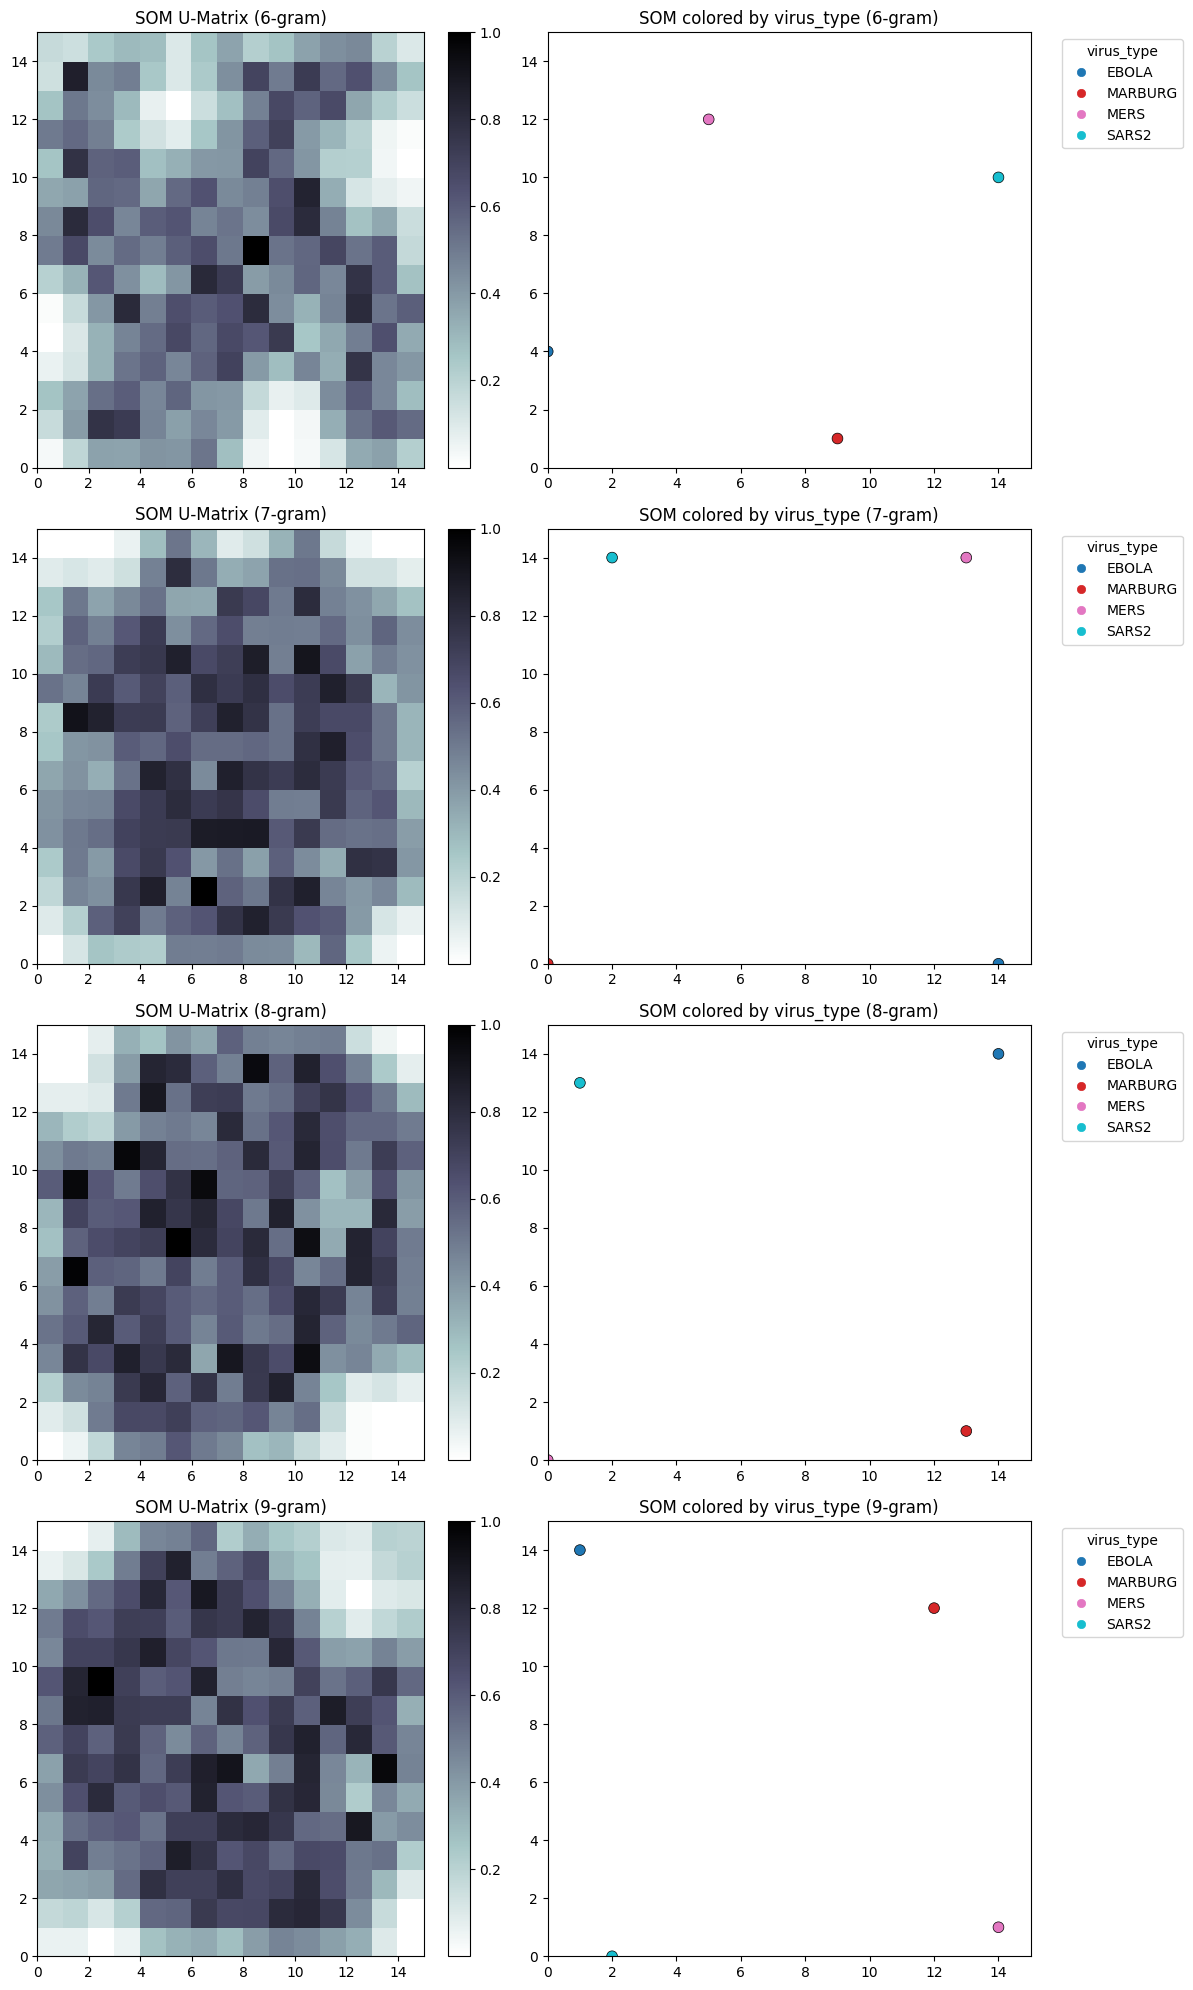

[{'dataset': '6-gram', 'n_viruses': 4, 'n_features': 4096, 'n_clusters': 4},
 {'dataset': '7-gram', 'n_viruses': 4, 'n_features': 16377, 'n_clusters': 4},
 {'dataset': '8-gram', 'n_viruses': 4, 'n_features': 63495, 'n_clusters': 4},
 {'dataset': '9-gram', 'n_viruses': 4, 'n_features': 195546, 'n_clusters': 4}]

In [10]:
som(datasets, som_x=15, som_y=15, iterations=1000)